In [1]:
# import all necessary packages
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils

from keras.models import Sequential, Model, load_model
from keras.layers.normalization import BatchNormalization
from keras.layers import Dense, Dropout, Activation, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D
import keras.backend as K

import os


Using TensorFlow backend.


In [2]:
print(keras.__version__)
print(tf.__version__)

2.0.8
1.3.0


In [3]:
# define the classes
Classes= ['airplane','angel','apple','baseball_bat','brain','birthday_cake','bear','butterfly','canoe','cello',
          'chair','chandelier','church','diamond','dishwasher','dragon','duck','elephant','fire_hydrant','flamingo',
          'flower','giraffe','guitar','hand','headphones','hurricane','ice_cream','jail','lion','lipstick',
          'map','moon','ocean','owl','pig','police_car','rabbit','rainbow','river','The_Mona_Lisa']

IMAGE_PER_CLASS = 10000 #20 images per class
NUM_CLASSES = len(Classes)

print('#Classes', NUM_CLASSES )
print('#Images per class', IMAGE_PER_CLASS)


#Classes 40
#Images per class 10000


# Generating Train and Test Data Set

In [4]:
# This cell is only if you are loading the data from scratch
# generate data set
def generate_data_set(classes, start_from, num_examples_per_class):
    quickdraws = [np.load("./quickdraw/{}.npy".format(qdraw))[start_from:(start_from+num_examples_per_class)] for qdraw in classes]
    
    # Concat the arrays together
    x_data = np.concatenate(quickdraws,axis=0)
    x_data.shape
    
    filename = 'MyData_'+str(NUM_CLASSES)+'class_'+str(num_examples_per_class)+'sample'+str(start_from)+'.npy'
    np.save(filename,x_data)
    print('File ', filename, ' saved')
    return filename

#Get the Data
train_file = generate_data_set(Classes, 20, IMAGE_PER_CLASS)
test_file = generate_data_set(Classes, 15000, IMAGE_PER_CLASS)

File  MyData_40class_10000sample20.npy  saved
File  MyData_40class_10000sample300.npy  saved


In [5]:
#image_train_data = np.load("./MyData_40class_50sample1000.npy")
#image_test_data = np.load("./MyData_40class_50sample20.npy")

image_train_data = np.load(train_file)
image_test_data = np.load(test_file)

print(image_train_data.shape)
print(image_test_data.shape)

(400000, 784)
(400000, 784)


In [6]:
## generate the labels for image
labels = [np.full((IMAGE_PER_CLASS,), Classes.index(qdraw)) for qdraw in Classes]
label_data = np.concatenate(labels,axis=0)

label_train_data = label_data
label_test_data = label_data

print(label_train_data.shape)
print(label_test_data.shape)
#label_data.shape



(400000,)
(400000,)


In [7]:
def show_object(obj):
    # Reshape 784 array into 28x28 image
    image = obj.reshape([28,28])
    fig, axes = plt.subplots(1, )
    fig.subplots_adjust(hspace=0.5, wspace=0.5)
    plt.imshow(image, cmap='gray_r')
    plt.show()

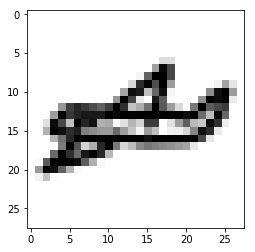

airplane


In [8]:
show_object(image_train_data[25])
print(Classes[label_train_data[25]])

In [10]:
np_utils.to_categorical(label_train_data[25], NUM_CLASSES)

array([[ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.]])

# Shuffling function

In [11]:
#shuffling function
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

image_train_data,label_train_data = unison_shuffled_copies(image_train_data,label_train_data)
image_test_data,label_test_data = unison_shuffled_copies(image_test_data,label_test_data)

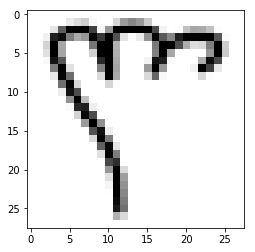

hand


In [12]:
show_object(image_train_data[25])
print(Classes[label_train_data[25]])

# One-Hot the labels

In [13]:
# convert label to one hot
label_train_data = np_utils.to_categorical(label_train_data, NUM_CLASSES)
label_test_data = np_utils.to_categorical(label_test_data, NUM_CLASSES)


In [14]:
label_train_data[25]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

# Reshape and normalized images

In [15]:
image_train_data = image_train_data.reshape(image_train_data.shape[0], 28, 28, 1)
image_test_data = image_test_data.reshape(image_test_data.shape[0], 28, 28, 1)

image_train_data = image_train_data.astype('float32')
image_test_data = image_test_data.astype('float32')


In [16]:
# normalize the image
image_train_data = image_train_data/255
image_test_data = image_test_data/255

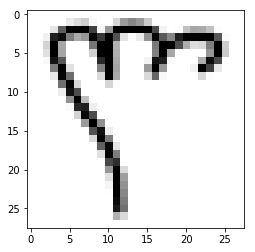

In [17]:
show_object(image_train_data[25]) # should still show a (pale) image,

# Generator 1

In [18]:
BATCH_SIZE = 64

In [19]:
#train_img_gen = ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3,
#                                   height_shift_range=0.08, zoom_range=0.08)

train_img_gen = ImageDataGenerator()
test_img_gen = ImageDataGenerator()

train_generator = train_img_gen.flow(image_train_data, label_train_data, batch_size=BATCH_SIZE)
test_generator = test_img_gen.flow(image_test_data, label_test_data, batch_size=BATCH_SIZE)

# Generator 2

In [13]:
def generator(features, labels, batch_size):
    # Create empty arrays to contain batch of features and labels#
    batch_features = np.zeros((batch_size, 64, 64, 3))
    batch_labels = np.zeros((batch_size,1))
    while True:
        for i in range(batch_size):
            # choose random index in features
            index= random.choice(len(features),1)
            batch_features[i] = some_processing(features[index])
            batch_labels[i] = labels[index]
        yield batch_features, batch_labels

NameError: name 'get_batches' is not defined

# Model 1

In [21]:
# define the training paramaters
EPOCHS = 10

In [24]:
#Define the model1
input_shape = (28, 28, 1) #1 channel, 28x28 size

inputs = Input(input_shape) 
x = Conv2D(filters=32, kernel_size=(3,3), strides=(1, 1), padding='same', activation='relu', name = "Conv2d_1")(inputs)
x = BatchNormalization(axis=-1)(x)
x = Conv2D(filters=32, kernel_size=(3,3), strides=(1, 1), padding='same', activation='relu', name = "Conv2d_2")(x)
x = MaxPooling2D(pool_size=(2, 2), padding='same', name = "Maxpool2d_1")(x)

x = Conv2D(filters=64, kernel_size=(3,3), strides=(1, 1), padding='same', activation='relu', name = "Conv2d_3")(x)
#x = BatchNormalization(axis=-1)(x)
#x = Conv2D(filters=64, kernel_size=(3,3), strides=(1, 1), padding='same', activation='relu', name = "Conv2d_4")(x)
x = MaxPooling2D(pool_size=(2, 2), padding='same', name = "Maxpool2d_2")(x)
x = Flatten()(x)
x = Dense(128, activation='softmax', name = "Dense_1")(x)
x = Dense(128, activation='softmax', name = "Dense_2")(x)
outputs = Dense(NUM_CLASSES, activation='softmax', name = "Outputlayer")(x)

model = Model(inputs, outputs)
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
Conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
Conv2d_2 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
Maxpool2d_1 (MaxPooling2D)   (None, 14, 14, 32)        0         
_________________________________________________________________
Conv2d_3 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
Maxpool2d_2 (MaxPooling2D)   (None, 7, 7, 64)          0         
__________

In [ ]:
#compile the model
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

#train the model
hist = model.fit_generator(train_generator,
                           epochs=EPOCHS,
                           steps_per_epoch=(IMAGE_PER_CLASS*NUM_CLASSES/BATCH_SIZE),
                           verbose=1,
                           max_queue_size=10,
                           validation_data=test_generator,
                           validation_steps=10)


Epoch 1/10
6250/6250 [==============================] - 777s - loss: 3.1044 - acc: 0.1466 - val_loss: 2.8636 - val_acc: 0.1672
Epoch 2/10
3993/6250 [==================>...........] - ETA: 272s - loss: 2.8884 - acc: 0.1641

In [ ]:
metrics = model.evaluate_generator(test_generator,10,10,workers=1,pickle_safe=False)
print("model accuracy:",metrics[1])

In [ ]:
model.save('Quickdraw.hdf5')

# Model 2

In [17]:
#define the model2 - sequencial

input_shape = (1, 28, 28) #1 channel, 28x28 size

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

#compile the model
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])



ValueError: Negative dimension size caused by subtracting 3 from 1 for 'conv2d_2/convolution' (op: 'Conv2D') with input shapes: [?,1,28,28], [3,3,28,32].

In [ ]:

img_rows = 28
img_cols = 28
x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)



In [ ]:
#train the model
model.fit(image_train_data, labal_train_data,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(image_test_data, label_test_data))
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [ ]:
#compile the model
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

#train the model
model.fit(image_train_data, labal_train_data,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          verbose=1,
          validation_data=(image_test_data, label_test_data))
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [ ]:
show_object(x_data[53000])
print(y_data[53000])